In [ ]:
!pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [ ]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ["human", "rgb_array"] }
    
    def __init__(self):


        # Maximum steps before we end the episode 
        self.max_timesteps = 12
        # Init timestep to 0
        self.timestep = 0

        self.environment_height, self.environment_width = 4,4
        # How much of the environment is visible to the agent
        self.observation_space = spaces.Discrete(self.environment_height * self.environment_width)
        # No of directions the agent can move in
        self.action_space = spaces.Discrete(4)

        # Agent starts at the first box
        self.agent_pos = np.asarray([0, 0])
        # Terminal position is bottom right square
        self.goal_pos = np.asarray([3, 3])
        self.reward_pos = np.asarray([[1,1],[1,3]])
        self.regret_pos = np.asarray([[3,1],[1,2]])
        self.reward_quantity = 2


    def reset(self, **kwargs):
        # Reset timesteps
        self.timestep = 0
        self.reward_pos = np.asarray([[1,1],[1,3]])
        self.agent_pos = np.asarray([0, 0])
        # TODO: Am I sending the right observation back?
        observation = 0
        # What's the point of info?
        info = {}
        print("OBSERVATION IN RESET:\n",observation)
        return observation, info
    
    def step(self, action, prob):
        print("ACTION TAKEN", action)
        rand = np.random.random()
        # if prob is not 1, then there's a 1-prob chance of picking a random action
        if rand > prob:
          # Generate a number between 0 and action_space(8)
          old_action = action
          action = np.random.randint(0, self.action_space.n)
          print("ACTION INTENDED VS TAKEN", old_action, action)

        # 4 possible actions in all directions
        if action == 0:
          # Move right
          self.agent_pos[1] += 1
        if action == 1:
          # Move down
          self.agent_pos[0] += 1
        if action == 2:
          # Move left
          self.agent_pos[1] -= 1
        if action == 3:
          # Move up
          self.agent_pos[0] -= 1
    

        # Comment this to demonstrate the truncation condition.
        # TODO: Make this wrap-around
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        observation = self.agent_pos[0] * 4 + self.agent_pos[1]
        
        reward = 0

        terminated = False
        # If the agent reached the goal, reward is 10 and terminated is true.
        if np.array_equal(self.agent_pos, self.goal_pos):
          reward = 10
          terminated = True

        # Else if it reaches a trap
        elif  any(np.array_equal(self.regret_pos[i], self.agent_pos) for i in range(len(self.regret_pos))):
          reward = -5
        # Else if it reaches the reward
        else:
          for i in range(len(self.reward_pos)):
            if np.array_equal(self.agent_pos, self.reward_pos[i]):
              self.reward_pos = np.delete(self.reward_pos, i, axis=0)
              reward = 3
              break

        # Increment timestep
        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps else terminated
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        info = {}
        
        return observation, reward, terminated, truncated, info
        
    def render(self):
        # first of all, the base transformation of the data points is needed
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xlim(0,self.environment_width)
        ax.set_ylim(0,self.environment_height)
        print("CURRENT AGENT POSITION", self.agent_pos)
        def plot_image(plot_pos):
          plot_agent, plot_reward, plot_goal, plot_regret = False, False, False, False

          # Figuring out what to plot
          if np.array_equal(self.agent_pos, plot_pos):
            plot_agent = True
          if self.reward_quantity > 0:
            if any(np.array_equal(self.reward_pos[i], plot_pos) for i in range(len(self.reward_pos))):
              plot_reward = True
          if any(np.array_equal(self.regret_pos[i], plot_pos) for i in range(len(self.regret_pos))):
            plot_regret = True
          if np.array_equal(self.goal_pos, plot_pos):
            plot_goal = True
          
          # # Actually plotting
          if plot_agent and plot_regret:
            mouseintrap = AnnotationBbox(OffsetImage(plt.imread('./mouseandtrap.jpg'), zoom=.8),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(mouseintrap)
          elif plot_agent and plot_reward:
            mousewithcheese = AnnotationBbox(OffsetImage(plt.imread('./mouseandcheese.jpg'), zoom=1),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(mousewithcheese)  
          elif plot_agent and plot_goal:
            agentatgoal = AnnotationBbox(OffsetImage(plt.imread('./mouseandgold.jpg'), zoom=.8),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agentatgoal)  
          elif plot_agent:
            agent = AnnotationBbox(OffsetImage(plt.imread('./mouse.jpg'), zoom=0.3),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agent)
          elif plot_regret:
            regret = AnnotationBbox(OffsetImage(plt.imread('./mousetrap.jpg'), zoom=1),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(regret)
          elif plot_reward:
            reward = AnnotationBbox(OffsetImage(plt.imread('./cheese.jpg'), zoom=0.5),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(reward)  
          elif plot_goal:
            goal = AnnotationBbox(OffsetImage(plt.imread('./gold.jpg'), zoom=1.2),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(goal)                                    

          


        
        # Don't know what this is for
        coordinates_state_mapping = {}
        for j in range(self.environment_height * self.environment_width): # j iterates 16 times (0 - 15)
          coordinates_state_mapping[j] = np.asarray([j % self.environment_width, int(np.floor(j/ self.environment_width))])

        for position in coordinates_state_mapping:
          plot_image(coordinates_state_mapping[position])

        plt.xticks([0,1,2,3])
        plt.yticks([0,1,2,3])
        plt.grid()
        plt.show()


        # plt.imshow(self.state)

In [ ]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    # We are randomly picking an action out of the available actions(0-7)
    return np.random.choice(self.action_space.n)

In [ ]:
env = GridEnvironment()
agent = RandomAgent(env)

OBSERVATION IN RESET:
 0


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ACTION TAKEN 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CURRENT AGENT POSITION [3 1]


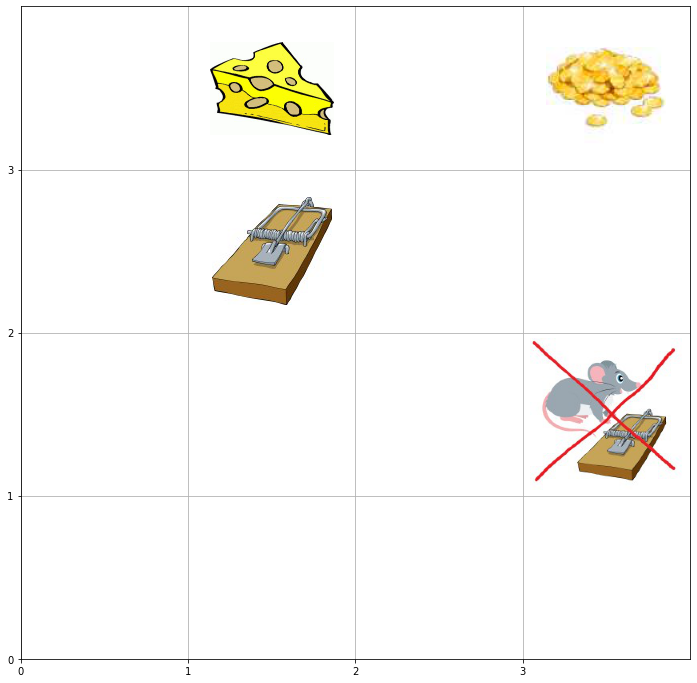

REWARD, OBS: 
 -5 13
TOTAL REWARD: 
 [0, 0, 0, 0, 0, 0, 3, 0, -5, 0, 0, -5] True


<IPython.core.display.Javascript object>

In [ ]:
obs, info = env.reset()
terminated, truncated = False, False
rewards = []
# prob 1 for deterministic, anything else between [0-1) for stochastic
prob = 1

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

while not terminated:
  action = agent.step(obs)
  obs, reward, terminated, truncated, info = env.step(action, prob)
  rewards.append(reward)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    env.render()
    print("REWARD, OBS: \n", reward, obs)
    print("TOTAL REWARD: \n", rewards, terminated)
  time.sleep(1)


In [ ]:
 

x = spaces.Discrete(8)


In [ ]:
x.n

8

In [ ]:
# Images from
#All of these are free for non-commercial use
https://lovepik.com/images/png-animal.html 
https://www.cleanpng.com/png-mousetrap-trapping-clip-art-mouse-trap-646405/download-png.html
http://clipart-library.com/img/1734718.gif
